In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import warnings
warnings.filterwarnings("ignore")
from math import radians, cos, sin, asin, sqrt
from sklearn import linear_model
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [6]:
data = pd.read_csv('df_mod.csv')

In [7]:
data.shape
#Creating a new column Date from the column "start_time" of the dataframe 
data["start_time"] = pd.to_datetime(data["start_time"])

In [8]:
data = data[data['end_lat'] != 0]
data.shape

(586779, 13)

In [9]:
#Creating a new column Date from the column "start_time" of the dataframe 
data["Date"] = pd.to_datetime(data["start_time"])


In [11]:
#Creating a copy of data since loading data takes a lot of time
data1 = data.copy()

In [12]:
#Dropping null values
data1 = data1.dropna() 
# Converting float values to interger
data1["end_station"] = data1["end_station"].astype(int)  
 #setting index to Date column
data1 = data1.sort_index() #Arranging dates 

In [13]:
# data1.head()

In [14]:
#length of end station is 142 and length of start station is 140
end_stn = list(set(data1.end_station))
start_stn = list(set(data1.start_station))
"""As length is not same of these two list, a search method is used to identify which element 
is missing from the start station, hence the next chunk of code is to find
the station number not in the start station list"""
remove_stn = []
for i in range(len(end_stn)):
    if end_stn[i] not in start_stn:
        remove_stn.append(end_stn[i])
#Updating end station list
end_stn = [stn for stn in end_stn if stn not in remove_stn]

In [15]:
#Removing rows with station number 4110,4143 and 4118 as it is discarded from the analysis
data1= data1[data1['end_station']!=4110]
data1 = data1[data1['end_station']!=4118]
data1 = data1[data1['start_station']!=4143]

In [16]:
#Setting plan_duration = 0 for passholder_type = Walk-up
data1['plan_duration'].loc[data1['passholder_type'] == "Walk-up"] = 0

#Setting annual pass = flex as both of them are the same
data1['passholder_type'].loc[data1['passholder_type'] == "Flex Pass"] = "Annual Pass"

In [17]:
#Calculating trip duration in minutes
data1['start_time']= pd.to_datetime(data1['start_time']) 
data1['end_time']= pd.to_datetime(data1['end_time']) 
data1['trip_duration_mins'] = (data1.end_time - data1.start_time)/ timedelta(minutes=1)

In [18]:
#Creating a copy of data since it takes time to load data
data2 = data1.copy()
data2 = data2[(data2['trip_duration_mins']>=0)]

In [19]:
print(data2.shape)
data2.head()

(586071, 15)


,trip_id,bike_id,start_station,end_station,trip_route_category,start_time,end_time,start_lat,start_lon,end_lat,end_lon,plan_duration,passholder_type,Date,trip_duration_mins
0,59256078,6417,4159,3042,One Way,2017-11-21 11:42:00,2017-11-21 12:37:00,34.145901,-118.11653,34.049301,-118.23880,0,Walk-up,2017-11-21 11:42:00,55.0
1,60223612,6453,4159,4138,One Way,2017-11-27 08:13:00,2017-11-27 08:41:00,34.145901,-118.11653,34.145691,-118.14823,0,Walk-up,2017-11-27 08:13:00,28.0
2,58576402,6650,4159,4138,One Way,2017-11-17 16:39:00,2017-11-17 16:57:00,34.145901,-118.11653,34.145691,-118.14823,30,Monthly Pass,2017-11-17 16:39:00,18.0
3,51293790,12327,4159,4138,One Way,2017-11-10 16:18:00,2017-11-10 16:33:00,34.145901,-118.11653,34.145691,-118.14823,30,Monthly Pass,2017-11-10 16:18:00,15.0
4,50594191,6000,4159,4138,One Way,2017-08-10 11:51:00,2017-08-10 12:12:00,34.145901,-118.11653,34.145691,-118.14823,0,Walk-up,2017-08-10 11:51:00,21.0


In [ ]:
#Create dummy variables for passholder type
one_hot_pass = pd.get_dummies(data3['passholder_type']).rename(columns={
            'Flex Pass': 'annual',
            'Monthly Pass': 'monthly',
            'One Day Pass': 'one_day',
            'Walk-up':'walk_up'})

#Create dummy variables for trip route category
one_hot_trip_type = pd.get_dummies(data3['trip_route_category']).rename(columns={
            'Round Trip': 'round_trip',
            'One Way': 'one_way'})

In [ ]:
data2 = pd.concat([data2, one_hot_trip_type,one_hot_pass], axis=1, sort=False)

In [ ]:
data2.to_csv('pricing_optimization.csv')

In [ ]:
import googlemaps

#Setting up my google api key
apiKey = 'XXXXXXXXXXXXXXXXXXXXXXXXXX'
gmaps = googlemaps.Client(key=apiKey)

#Entering latitude and longitude to be used
start_loc = "34.04739000000001,-118.21884900000035"
end_loc = "34.04652000000171,-118.23741100000254"

#Calculating distance by setting the travel mode = bicycling
result = gmaps.distance_matrix(start_loc, end_loc, mode="bicycling")

#Saving Distance and duration in the variables
dist = result["rows"][0]["elements"][0]["distance"]["value"]
dur = result["rows"][0]["elements"][0]["duration"]["value"]
dur = dur/60.0

#printing results
print(" Cycling Distance(meters): ", dist)
print(" Expected Cycling Time(min): ", dur)
print(result)

In [ ]:
unique_coordinates = data2[data2['round_trip']==0]
unique_coordinates = data2[['start_lat', 'start_lon', 'end_lat','end_lon']].drop_duplicates()
print(unique_coordinates.shape)

In [ ]:
def distance_calc(df):
    start_loc = (df['start_lat'], df['start_lon'])
    end_loc = (df['end_lat'], df['end_lon'])
    #Setting up my google api key
    apiKey = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
    gmaps = googlemaps.Client(key=apiKey)
    result = gmaps.distance_matrix(start_loc, end_loc, mode="bicycling")
    dist = result["rows"][0]["elements"][0]["distance"]["value"]
    return dist

In [ ]:
import googlemaps

#Dropping rows where coordinates are 0,0 
unique_coordinates = unique_coordinates.loc[(unique_coordinates!=0).any(axis=1)]

#Calculating distance
unique_coordinates['distance'] = unique_coordinates.head(5).apply (lambda row: distance_calc(row),axis=1)
unique_coordinates.head(10)

In [ ]:
#Calculating Distance traveled 
def calc_dist(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [20]:
import os
os.chdir('C:\\Users\\Sayeed Alvi\\Downloads')

In [21]:
os.getcwd()

'C:\\Users\\Sayeed Alvi\\Downloads'

In [22]:
unique = pd.read_csv("unique_coordinates_distance.csv")
unique = unique.iloc[:, 2:]
unique.head()

,start_lat,start_lon,end_lat,end_lon,distance
0,34.042061,-118.26338,34.044159,-118.25158,1550
1,34.045609,-118.23703,34.046070,-118.23309,367
2,34.049198,-118.25283,34.046810,-118.25698,629
3,34.058319,-118.24609,34.058319,-118.24609,0
4,34.046070,-118.23309,34.046612,-118.26273,3960


In [23]:
unique.shape

(13734, 5)

In [24]:
# data2 = data2.set_index('Date')
# data2 = data2.sort_index()
# data2 = data2.reset_index()
data2 = data2.drop('Date', 1)
data2.head()

,trip_id,bike_id,start_station,end_station,trip_route_category,start_time,end_time,start_lat,start_lon,end_lat,end_lon,plan_duration,passholder_type,trip_duration_mins
0,59256078,6417,4159,3042,One Way,2017-11-21 11:42:00,2017-11-21 12:37:00,34.145901,-118.11653,34.049301,-118.23880,0,Walk-up,55.0
1,60223612,6453,4159,4138,One Way,2017-11-27 08:13:00,2017-11-27 08:41:00,34.145901,-118.11653,34.145691,-118.14823,0,Walk-up,28.0
2,58576402,6650,4159,4138,One Way,2017-11-17 16:39:00,2017-11-17 16:57:00,34.145901,-118.11653,34.145691,-118.14823,30,Monthly Pass,18.0
3,51293790,12327,4159,4138,One Way,2017-11-10 16:18:00,2017-11-10 16:33:00,34.145901,-118.11653,34.145691,-118.14823,30,Monthly Pass,15.0
4,50594191,6000,4159,4138,One Way,2017-08-10 11:51:00,2017-08-10 12:12:00,34.145901,-118.11653,34.145691,-118.14823,0,Walk-up,21.0


In [25]:
new_df = pd.merge(data2, unique,  how='left', left_on=['start_lat','start_lon','end_lat','end_lon'], right_on = ['start_lat','start_lon','end_lat','end_lon'])
new_df.head()

,trip_id,bike_id,start_station,end_station,trip_route_category,start_time,end_time,start_lat,start_lon,end_lat,end_lon,plan_duration,passholder_type,trip_duration_mins,distance
0,59256078,6417,4159,3042,One Way,2017-11-21 11:42:00,2017-11-21 12:37:00,34.145901,-118.11653,34.049301,-118.23880,0,Walk-up,55.0,19604.0
1,60223612,6453,4159,4138,One Way,2017-11-27 08:13:00,2017-11-27 08:41:00,34.145901,-118.11653,34.145691,-118.14823,0,Walk-up,28.0,3302.0
2,58576402,6650,4159,4138,One Way,2017-11-17 16:39:00,2017-11-17 16:57:00,34.145901,-118.11653,34.145691,-118.14823,30,Monthly Pass,18.0,3302.0
3,51293790,12327,4159,4138,One Way,2017-11-10 16:18:00,2017-11-10 16:33:00,34.145901,-118.11653,34.145691,-118.14823,30,Monthly Pass,15.0,3302.0
4,50594191,6000,4159,4138,One Way,2017-08-10 11:51:00,2017-08-10 12:12:00,34.145901,-118.11653,34.145691,-118.14823,0,Walk-up,21.0,3302.0


In [26]:
new_df.trip_duration_mins.describe()

count    586071.000000
mean        216.287172
std        3020.092529
min           1.000000
25%           7.000000
50%          12.000000
75%          24.000000
max      215836.000000
Name: trip_duration_mins, dtype: float64

In [29]:
cluster1 = pd.read_csv('df_merge1.csv')
cluster2 = pd.read_csv('df_merge2.csv')
cluster3 = pd.read_csv('df_merge3.csv')
cluster4 = pd.read_csv('df_merge4.csv')

In [30]:
cluster1.head()

,trip_id,bike_id,start_station,end_station,trip_route_category,start_time,end_time,start_lat,start_lon,end_lat,end_lon,plan_duration,passholder_type,Start Station,Start Lat,Start Lon
0,110612093,6244,4276,3005,One Way,2/12/2018 8:46,2/12/2018 11:01,34.04739,-118.218849,34.0485,-118.258537,1,One Day Pass,4276,34.04739,-118.218849
1,110612094,6135,4276,3005,One Way,2/12/2018 8:46,2/12/2018 11:01,34.04739,-118.218849,34.0485,-118.258537,1,One Day Pass,4276,34.04739,-118.218849
2,110612087,6241,4276,3005,One Way,2/12/2018 8:47,2/12/2018 11:01,34.04739,-118.218849,34.0485,-118.258537,1,One Day Pass,4276,34.04739,-118.218849
3,110612090,6032,4276,3005,One Way,2/12/2018 8:47,2/12/2018 11:01,34.04739,-118.218849,34.0485,-118.258537,1,One Day Pass,4276,34.04739,-118.218849
4,110612065,6582,4276,3005,One Way,2/12/2018 9:01,2/12/2018 11:01,34.04739,-118.218849,34.0485,-118.258537,1,Walk-up,4276,34.04739,-118.218849


In [31]:
cluster1 = cluster1['Start Station'].unique()
cluster2 = cluster2['Start Station'].unique()
cluster3 = cluster3['Start Station'].unique()
cluster4 = cluster4['Start Station'].unique()

In [32]:
def f(row):
    if row['start_station'] in cluster1:
        val = 'Downtown LA'
    elif row['start_station'] in cluster2:
        val = 'Pasadena'
    elif row['start_station'] in cluster3:
          val = 'Venice'
    else:
        val = 'Port of LA'
    return val

In [33]:
new_df['Region'] = new_df.apply(f, axis = 1)
# new_df.head()
new_df.Region.value_counts()

Downtown LA    451705
Venice          77475
Pasadena        46024
Port of LA      10867
Name: Region, dtype: int64

In [35]:
new_df['Distance (miles)'] = new_df['distance'].apply(lambda x: x*0.000621371).round(2)

new_df.head()

,trip_id,bike_id,start_station,end_station,trip_route_category,start_time,end_time,start_lat,start_lon,end_lat,end_lon,plan_duration,passholder_type,trip_duration_mins,distance,Region,Distance (miles)
0,59256078,6417,4159,3042,One Way,2017-11-21 11:42:00,2017-11-21 12:37:00,34.145901,-118.11653,34.049301,-118.23880,0,Walk-up,55.0,19604.0,Pasadena,12.18
1,60223612,6453,4159,4138,One Way,2017-11-27 08:13:00,2017-11-27 08:41:00,34.145901,-118.11653,34.145691,-118.14823,0,Walk-up,28.0,3302.0,Pasadena,2.05
2,58576402,6650,4159,4138,One Way,2017-11-17 16:39:00,2017-11-17 16:57:00,34.145901,-118.11653,34.145691,-118.14823,30,Monthly Pass,18.0,3302.0,Pasadena,2.05
3,51293790,12327,4159,4138,One Way,2017-11-10 16:18:00,2017-11-10 16:33:00,34.145901,-118.11653,34.145691,-118.14823,30,Monthly Pass,15.0,3302.0,Pasadena,2.05
4,50594191,6000,4159,4138,One Way,2017-08-10 11:51:00,2017-08-10 12:12:00,34.145901,-118.11653,34.145691,-118.14823,0,Walk-up,21.0,3302.0,Pasadena,2.05


In [52]:
new_df2 = new_df3

In [53]:
new_df2["pickup_dayofweek"] = new_df2.start_time.dt.dayofweek
new_df2["pickup_weekday_name"] = new_df2.start_time.dt.weekday_name
new_df2["pickup_hour"] = new_df2.start_time.dt.hour
new_df2["pickup_month"] = new_df2.start_time.dt.month

In [68]:
new_df2.head()

,trip_id,bike_id,start_station,end_station,trip_route_category,start_time,end_time,start_lat,start_lon,end_lat,end_lon,plan_duration,passholder_type,trip_duration_mins,distance,Region,pickup_dayofweek,pickup_weekday_name,pickup_hour,pickup_month
0,4767292,6127,3034,3055,One Way,2016-01-08 00:12:00,2016-01-08 00:49:00,34.042061,-118.26338,34.044159,-118.25158,0,Walk-up,37.0,1550.0,Downtown LA,4,Friday,0,1
1,4767291,6026,3034,3055,One Way,2016-01-08 00:13:00,2016-01-08 00:49:00,34.042061,-118.26338,34.044159,-118.25158,0,Walk-up,36.0,1550.0,Downtown LA,4,Friday,0,1
2,4767290,5990,3021,3022,One Way,2016-01-08 00:18:00,2016-01-08 00:43:00,34.045609,-118.23703,34.046070,-118.23309,30,Monthly Pass,25.0,367.0,Downtown LA,4,Friday,0,1
3,4767289,6585,3063,3064,One Way,2016-01-08 00:23:00,2016-01-08 01:46:00,34.049198,-118.25283,34.046810,-118.25698,0,Walk-up,83.0,629.0,Downtown LA,4,Friday,0,1
4,4767288,6069,3063,3064,One Way,2016-01-08 00:25:00,2016-01-08 01:46:00,34.049198,-118.25283,34.046810,-118.25698,0,Walk-up,81.0,629.0,Downtown LA,4,Friday,0,1


In [37]:
os.chdir('C:\\Users\\Sayeed Alvi\\Desktop\\Images')

In [38]:
os.getcwd()

'C:\\Users\\Sayeed Alvi\\Desktop\\Images'

In [39]:
new_df3['Distance (miles)'].describe()

count    577223.000000
mean          0.926977
std           0.824952
min           0.000000
25%           0.440000
50%           0.800000
75%           1.300000
max          27.360000
Name: Distance (miles), dtype: float64

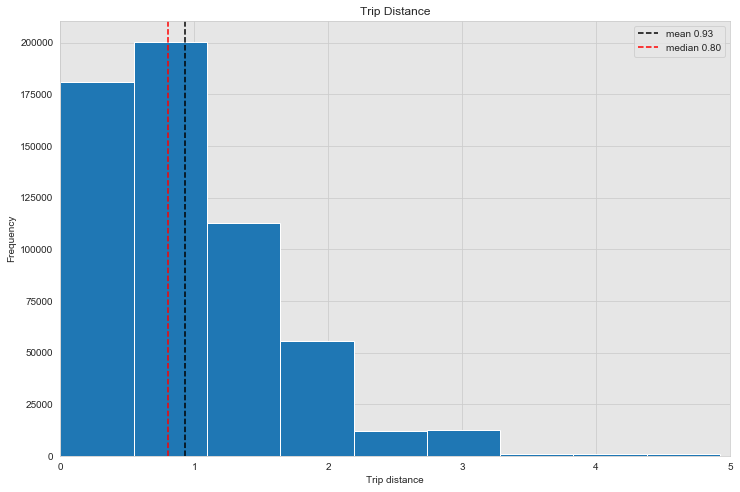

In [92]:
fig = plt.figure(figsize=(12,8))
plt.hist(new_df3['Distance (miles)'],bins =50,edgecolor='white')
plt.title('Trip Distance')
plt.axvline(new_df3['Distance (miles)'].mean(), c='black',label='mean %0.2f'%(new_df3['Distance (miles)'].mean()),ls='--')
plt.axvline(new_df3['Distance (miles)'].median(), c='red',label='median %0.2f'%(new_df3['Distance (miles)'].median()),ls='--')
plt.xlabel('Trip distance')
plt.ylabel('Frequency')
plt.legend()
plt.xlim(0,5)
plt.show()
fig.savefig('trip_distance.png', dpi=200)


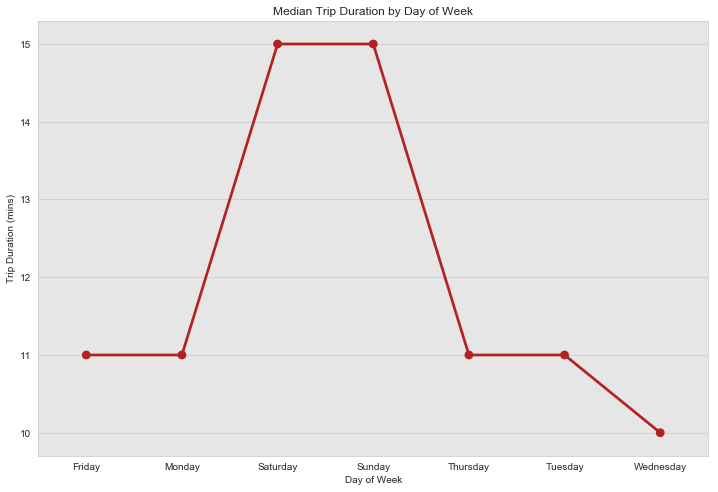

In [88]:
df_train_agg = new_df2.groupby('pickup_weekday_name')['trip_duration_mins'].aggregate(np.median).reset_index()
import seaborn as sns
fig = plt.figure(figsize=(12,8))
sns.pointplot(df_train_agg.pickup_weekday_name.values, df_train_agg.trip_duration_mins.values, color = 'firebrick')
plt.xlabel('Day of Week')
plt.title('Median Trip Duration by Day of Week')
sns.set_style("whitegrid", {"axes.facecolor": ".9"})
plt.ylabel('Trip Duration (mins)')
plt.show()
fig.savefig('trip_duration_dayofweek.png', dpi=200)

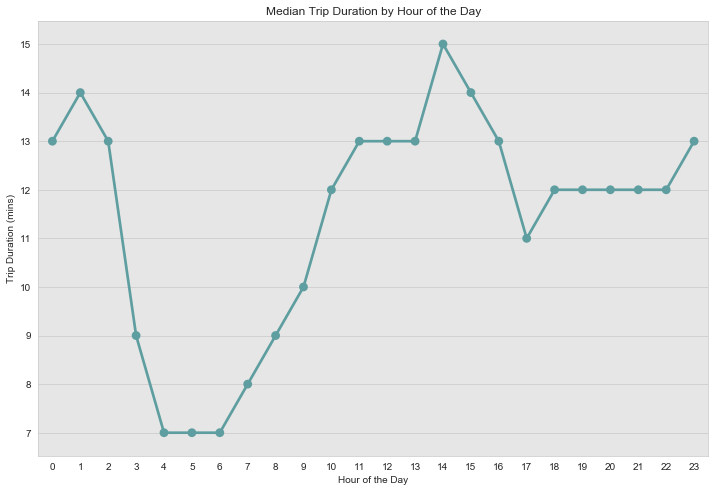

In [87]:
import seaborn as sns
df_train_agg = new_df2.groupby('pickup_hour')['trip_duration_mins'].aggregate(np.median).reset_index()
fig = plt.figure(figsize=(12,8))
sns.pointplot(df_train_agg.pickup_hour.values, df_train_agg.trip_duration_mins.values, color = 'cadetblue')
plt.xlabel('Hour of the Day')
plt.title('Median Trip Duration by Hour of the Day')
sns.set_style("whitegrid", {"axes.facecolor": ".9"})
plt.ylabel('Trip Duration (mins)')
plt.show()
fig.savefig('trip_duration_hour', dpi=200)

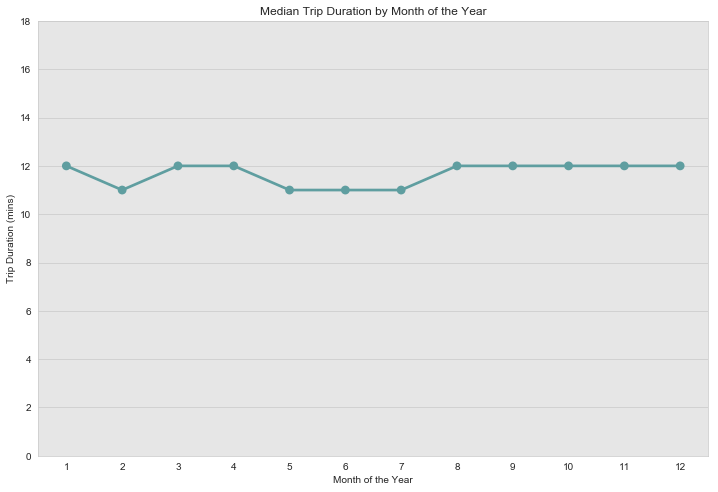

In [86]:
df_train_agg = new_df2.groupby('pickup_month')['trip_duration_mins'].aggregate(np.median).reset_index()
fig = plt.figure(figsize=(12,8))
sns.pointplot(df_train_agg.pickup_month.values, df_train_agg.trip_duration_mins.values, color = 'cadetblue')
plt.xlabel('Month of the Year')
plt.title('Median Trip Duration by Month of the Year')
plt.ylabel('Trip Duration (mins)')
sns.set_style("whitegrid", {"axes.facecolor": ".9"})
plt.ylim(0,18)
plt.show()
fig.savefig('trip_duration_month', dpi=200)

In [71]:
df_train_agg.head()

,pickup_weekday_name,trip_duration_mins
0,Friday,11.0
1,Monday,11.0
2,Saturday,15.0
3,Sunday,15.0
4,Thursday,11.0


In [72]:
df_train_agg2 = new_df2.groupby('pickup_weekday_name')['trip_duration_mins'].aggregate(np.sum).reset_index()

# plt.figure(figsize=(12,8))
# sns.pointplot(df_train_agg.pickup_weekday_name.values, df_train_agg.trip_duration.values)
# plt.show()
df_train_agg2.head()

,pickup_weekday_name,trip_duration_mins
0,Friday,17699729.0
1,Monday,18149448.0
2,Saturday,19168394.0
3,Sunday,18980455.0
4,Thursday,18675322.0


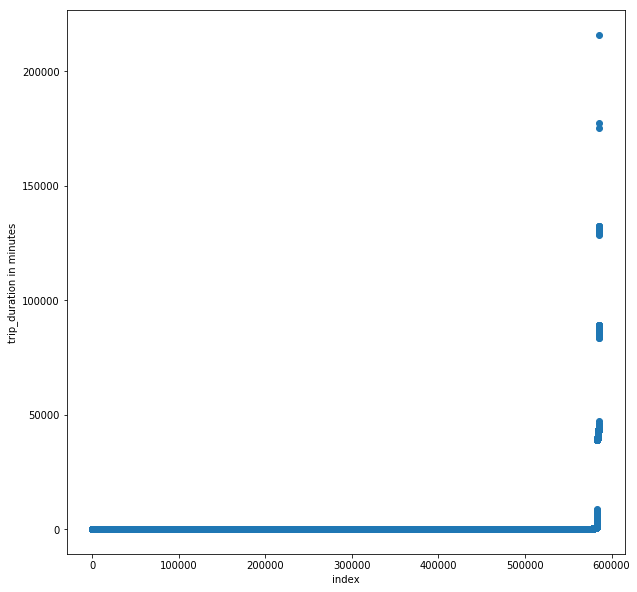

In [64]:
plt.figure(figsize=(10,10))
plt.scatter(range(len(new_df["trip_duration_mins"])), np.sort(new_df["trip_duration_mins"]))
plt.xlabel('index')
plt.ylabel('trip_duration in minutes')
plt.show()

In [ ]:
data2 = data2[(data2['trip_duration_mins']>=0) & (data2['trip_duration_mins']<50)]
data2 = data2[data2['Distance'] <50]
data2.shape

In [ ]:
month = 'month'
week = 'week'
day = 'day'
hour = 'hour'
def grouping(data,col):
    '''
    Stacking dataset on the basis of start_station
    Args: data = dataframe
          col = column name/ time frame
    Returns: Stacked dataframe with index resetted
    '''
    df = data.copy()
    df["Year"]=df.start_time.dt.year
    if col.lower() == 'month':
        col = col.capitalize()
        df[col] = df.start_time.dt.month
    elif col.lower() == 'week':
        col = col.capitalize()
        df[col] = df.start_time.dt.week
    elif col.lower() == 'day':
        col = col.capitalize()
        df[col] = df.start_time.dt.day
    elif col.lower() == 'hour':
        col = col.capitalize()
        df[col] = df.start_time.dt.hour
    else:
        return print('Unable to extract time from index!!')
    df_sum = df.groupby(by=["start_station","Year",col]).sum()[['Distance', 'trip_duration_mins']]
    df_count = df.groupby(by=["start_station","Year",col]).count()[['trip_id']]
    df = pd.concat([df_sum, df_count], axis=1)
    df = df.reset_index()
    return df

In [ ]:
data3 = grouping(data2,month)
#data3 = grouping(common,week)

In [ ]:
data3.head(20)

In [ ]:
#Setting offset for continuity in months
data3.loc[data3['Year']==2017, 'Month'] = data3['Month']+12
data3.loc[data3['Year']==2018, 'Month'] = data3['Month']+24

In [ ]:
data3 = data3[data3['start_station']!=4276]

In [ ]:
station = list(set(data3.start_station))
r_squared = []
#Looping over all the stations to fit linear regressions individually
for i in range(len(station)):
    stn = station[i]
    df = data3.loc[data3['start_station']==stn]
    x = df[['Distance','trip_duration_mins']]
    y = df["trip_id"]
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    print(X_train)
    reg = linear_model.LinearRegression()
    print(stn)
    est2 = reg.fit(X_train,y_train)
    ypred = est2.predict(x) #predicting y values on test dataset
    score = r2_score(y,ypred) #Calculating r-squared value on the test data
    r_squared.append(score)
r_squared

In [ ]:
df = data3.loc[data3['start_station']==4273]
x = df[['Distance','trip_duration_mins']]
y = df["trip_id"]
X_train, X_test, y_train, y_test = train_test_split( #Splitting data into train & test
            x, y, test_size=0.33, random_state=42)
reg = linear_model.LinearRegression()
est2 = reg.fit(X_train,y_train)
ypred = est2.predict(X_test) #predicting y values on test dataset
score = r2_score(y_test,ypred) #Calculating r-squared value on the test data
#r_squared.append(score)
score

In [ ]:
#Checking whether there is time series in the data
import matplotlib.pyplot as plt
plt.plot(df['Week'],df['trip_id'])
plt.show()

In [1]:
ih[-5:]

NameError: name 'ih' is not defined

In [58]:
os.chdir('C:\\Users\\Sayeed Alvi\\Downloads')

In [57]:
os.getcwd()

'C:\\Users\\Sayeed Alvi\\Desktop\\Images'

In [59]:
df_weather = pd.read_csv('df_final.csv')

In [60]:
df_weather.head()

,Unnamed: 0,Date,Unnamed: 0.1,bike_id,distance,end_lat,end_lon,end_station,end_time,median,...,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,AWND,PRCP,TAVG,TMAX,TMIN
0,0,2016-07-07,10752,6059,617,34.051102,-118.26456,3052,2016-07-07 21:14:00,10.0,...,USW00023174,"LOS ANGELES INTERNATIONAL AIRPORT, CA US",33.938,-118.3888,29.6,8.5,0.0,68,75,64
1,1,2016-07-07,13506,6528,1600,34.049198,-118.25283,3063,2016-07-07 16:57:00,10.0,...,USW00023174,"LOS ANGELES INTERNATIONAL AIRPORT, CA US",33.938,-118.3888,29.6,8.5,0.0,68,75,64
2,2,2016-07-07,37228,6137,636,34.048550,-118.25905,3005,2016-07-07 22:39:00,10.0,...,USW00023174,"LOS ANGELES INTERNATIONAL AIRPORT, CA US",33.938,-118.3888,29.6,8.5,0.0,68,75,64
3,3,2016-07-07,44384,6717,1700,34.039219,-118.23649,3054,2016-07-07 13:04:00,10.0,...,USW00023174,"LOS ANGELES INTERNATIONAL AIRPORT, CA US",33.938,-118.3888,29.6,8.5,0.0,68,75,64
4,4,2016-07-07,45207,6476,1935,34.039219,-118.23649,3054,2016-07-07 20:49:00,10.0,...,USW00023174,"LOS ANGELES INTERNATIONAL AIRPORT, CA US",33.938,-118.3888,29.6,8.5,0.0,68,75,64


In [63]:
df_weather['Date']= pd.to_datetime(df_weather['Date'])

In [65]:
df_weather["pickup_month"] = df_weather.Date.dt.month
df_weather.head()

,Unnamed: 0,Date,Unnamed: 0.1,bike_id,distance,end_lat,end_lon,end_station,end_time,median,...,NAME,LATITUDE,LONGITUDE,ELEVATION,AWND,PRCP,TAVG,TMAX,TMIN,pickup_month
0,0,2016-07-07,10752,6059,617,34.051102,-118.26456,3052,2016-07-07 21:14:00,10.0,...,"LOS ANGELES INTERNATIONAL AIRPORT, CA US",33.938,-118.3888,29.6,8.5,0.0,68,75,64,7
1,1,2016-07-07,13506,6528,1600,34.049198,-118.25283,3063,2016-07-07 16:57:00,10.0,...,"LOS ANGELES INTERNATIONAL AIRPORT, CA US",33.938,-118.3888,29.6,8.5,0.0,68,75,64,7
2,2,2016-07-07,37228,6137,636,34.048550,-118.25905,3005,2016-07-07 22:39:00,10.0,...,"LOS ANGELES INTERNATIONAL AIRPORT, CA US",33.938,-118.3888,29.6,8.5,0.0,68,75,64,7
3,3,2016-07-07,44384,6717,1700,34.039219,-118.23649,3054,2016-07-07 13:04:00,10.0,...,"LOS ANGELES INTERNATIONAL AIRPORT, CA US",33.938,-118.3888,29.6,8.5,0.0,68,75,64,7
4,4,2016-07-07,45207,6476,1935,34.039219,-118.23649,3054,2016-07-07 20:49:00,10.0,...,"LOS ANGELES INTERNATIONAL AIRPORT, CA US",33.938,-118.3888,29.6,8.5,0.0,68,75,64,7


In [83]:
os.chdir('C:\\Users\\Sayeed Alvi\\Desktop\\Images')

In [84]:
os.getcwd()

'C:\\Users\\Sayeed Alvi\\Desktop\\Images'

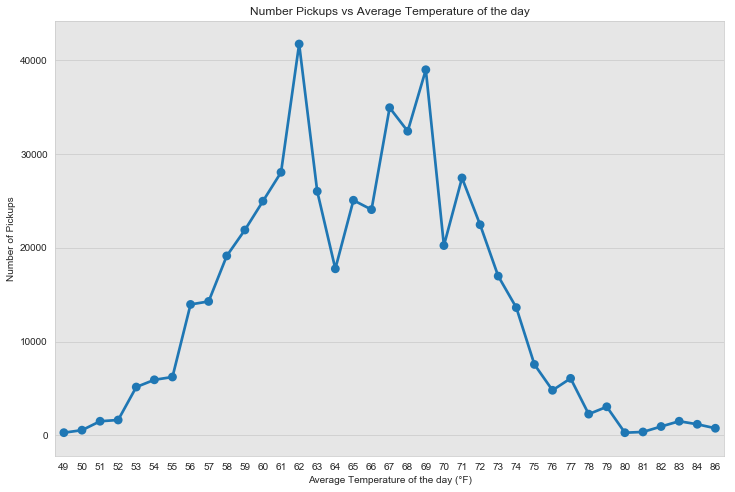

In [85]:
df_train_agg = df_weather.groupby(by=['TAVG' ])['Unnamed: 0.1'].count().reset_index()
fig = plt.figure(figsize=(12,8))
sns.pointplot(df_train_agg.TAVG.values, df_train_agg['Unnamed: 0.1'].values, ci = None)
plt.xlabel('Average Temperature of the day (°F)')
plt.title('Number Pickups vs Average Temperature of the day')
plt.ylabel('Number of Pickups')
sns.set_style("whitegrid", {"axes.facecolor": ".9"})
plt.show()
fig.savefig('temp_month', dpi=200)
# df_train_agg.head()

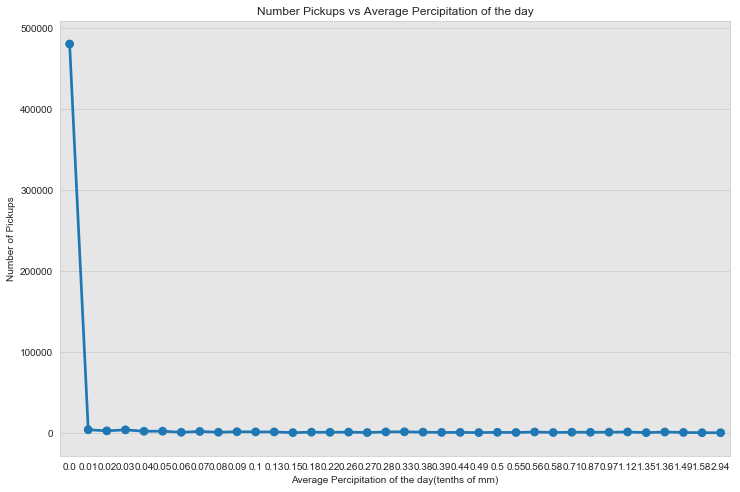

In [94]:
df_train_agg = df_weather.groupby(by=['PRCP' ])['Unnamed: 0.1'].count().reset_index()
fig = plt.figure(figsize=(12,8))
sns.pointplot(df_train_agg.PRCP.values, df_train_agg['Unnamed: 0.1'].values, ci = None)
plt.xlabel('Average Percipitation of the day(tenths of mm)')
plt.title('Number Pickups vs Average Percipitation of the day')
plt.ylabel('Number of Pickups')
sns.set_style("whitegrid", {"axes.facecolor": ".9"})
plt.show()
fig.savefig('prcp_month', dpi=200)

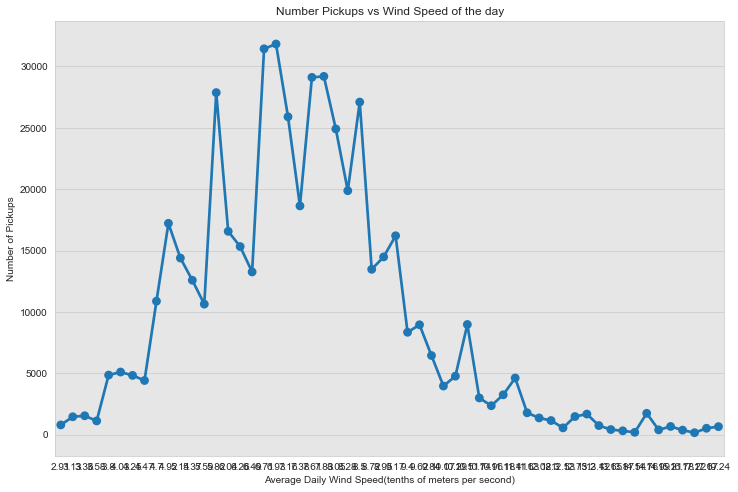

In [120]:
df_train_agg = df_weather.groupby(by=['AWND' ])['Unnamed: 0.1'].count().reset_index()
fig = plt.figure(figsize=(12,8))
sns.pointplot(df_train_agg.AWND.values, df_train_agg['Unnamed: 0.1'].values, ci = None)
plt.xlabel('Average Daily Wind Speed(tenths of meters per second)')
plt.title('Number Pickups vs Wind Speed of the day')
plt.ylabel('Number of Pickups')
# plt.xlim(0,30)
sns.set_style("whitegrid", {"axes.facecolor": ".9"})
plt.show()
fig.savefig('Wind_month', dpi=200)

In [96]:
df_train_agg.AWND.describe()

count    56.000000
mean      9.375179
std       4.165561
min       2.910000
25%       5.985000
50%       9.060000
75%      12.357500
max      19.240000
Name: AWND, dtype: float64